# ML Foreclosure Binary Classification - 2.5% Sample data

    target = zeroBalCode (set to object dtype) 
    Binary classification sets zeroBalCode to either "0" or "1" for the 7 possible outcomes
    
    "0" = "Loan Success"
        * 01 = Prepaid or Matured

    "1" =  "Loan Failure" - Most likely loss of money (but not necessarily) one of below conditions:
        * 02 = Third Party Sale
        * 03 = Short Sale
        * 06 = Repurchased
        * 09 = Deed-in-Lieu,REO
        * 15 = Note Sale
        * 16 = Reperforming Loan Sale

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#!pip install pycaret
from imblearn.over_sampling import RandomOverSampler
from pycaret.classification import *
#from pycaret.regression import *

# Importing the data - only use *.ML.csv files!!!
If you have *.MLReady.csv then [click here](#MLReady)

In [50]:
df=pd.read_csv("data/FannieAcq2000-19FMac30-sample2pt5.csv")
df.head()

,Unnamed: 0,id,origIntRate,origUPB,origLoanTerm,origDate,origLTV,origCLTV,numBorrowers,origDebtIncRatio,...,UT,VA,VI,VT,WA,WI,WV,WY,rank,deal
0,71469,376291890107,7.625,171000,360,2000-09-01,80.0,80.0,1.0,27.0,...,0,0,0,0,0,0,0,0,3,Discount
1,1230294,519934105202,5.750,150000,360,2003-08-01,75.0,75.0,2.0,15.0,...,0,0,0,0,0,0,0,0,3,Discount
2,223904,891550447380,6.875,110000,180,2001-05-01,88.0,88.0,1.0,58.0,...,0,0,0,0,0,0,0,0,3,Discount
3,430311,453962752520,6.875,228000,360,2001-12-01,75.0,75.0,1.0,60.0,...,0,0,0,0,0,0,0,0,3,Discount
4,1053491,818902249968,5.500,248000,360,2003-04-01,80.0,80.0,2.0,12.0,...,0,0,0,0,0,0,0,0,3,Discount


In [51]:
pd.options.display.max_info_columns

100

In [52]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66582 entries, 0 to 66581
Data columns (total 191 columns):
Unnamed: 0                                                              int64
id                                                                      int64
origIntRate                                                             float64
origUPB                                                                 int64
origLoanTerm                                                            int64
origDate                                                                object
origLTV                                                                 float64
origCLTV                                                                float64
numBorrowers                                                            float64
origDebtIncRatio                                                        float64
zipCode                                                                 int64
pMIperct             

In [53]:
df.info(verbose=True, buf=None, max_cols=True, memory_usage=None, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66582 entries, 0 to 66581
Data columns (total 191 columns):
Unnamed: 0                                                              66582 non-null int64
id                                                                      66582 non-null int64
origIntRate                                                             66582 non-null float64
origUPB                                                                 66582 non-null int64
origLoanTerm                                                            66582 non-null int64
origDate                                                                66582 non-null object
origLTV                                                                 66582 non-null float64
origCLTV                                                                66582 non-null float64
numBorrowers                                                            66582 non-null float64
origDebtIncRatio                            

## Remove columns not involved in 'Foreclosure or Not' query

In [54]:
df.drop(['Unnamed: 0','id','deal','deliqGood','deliqBad','deliqMax'],1,inplace=True)

In [56]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66582 entries, 0 to 66581
Data columns (total 185 columns):
origIntRate                                                             float64
origUPB                                                                 int64
origLoanTerm                                                            int64
origDate                                                                object
origLTV                                                                 float64
origCLTV                                                                float64
numBorrowers                                                            float64
origDebtIncRatio                                                        float64
zipCode                                                                 int64
pMIperct                                                                float64
mortInsType                                                             float64
bestCreditScore  

## Engineer originDate into Date features

In [57]:
df['origDate'] = pd.to_datetime(df['origDate'])

In [58]:
df['origYear'] = df['origDate'].dt.year
df['origMonth'] = df['origDate'].dt.month

In [59]:
df.drop(['origDate'],1,inplace=True)

In [60]:
df[['origYear','origMonth']].tail()

,origYear,origMonth
66577,2008,7
66578,2000,3
66579,2003,10
66580,2008,4
66581,2008,10


# Turn zero Balance Code Into binary "0" GOOD and "1" BAD

In [61]:
df.zeroBalCode.unique()

array([ 1.,  3., 15.,  9., 16.,  6.,  2.])

In [62]:
df['zeroBalCode'] = df.zeroBalCode.replace(1,0)
df['zeroBalCode'] = df.zeroBalCode.replace([9,3,16,6,2,15],1)

In [63]:
df.zeroBalCode.unique()

array([0., 1.])

In [64]:
#Checking datatypes of individual feature
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66582 entries, 0 to 66581
Columns: 186 entries, origIntRate to origMonth
dtypes: float64(22), int64(164)
memory usage: 94.5 MB


# Review values for dates and slice (if needed) the timeframe you want

In [65]:
df.origYear.unique()

array([2000, 2003, 2001, 2005, 2002, 2007, 2004, 2009, 2015, 2006, 2013,
       2017, 2008, 2010, 2012, 2018, 2011, 2014, 2016, 1999, 2019],
      dtype=int64)

In [66]:
df['origMonth'].unique()

array([ 9,  8,  5, 12,  4,  6, 10,  1,  2,  7,  3, 11], dtype=int64)

# Coerce the column dtype (int in this case)

In [69]:
df = df.astype({'origLTV':'int','numBorrowers':'int','origDebtIncRatio':'int',\
               'mortInsType':'int','bestCreditScore':'int',\
               'worstCreditScore':'int','avgCreditScore':'int','zeroBalCode':'int'})
#,'zeroBalCode':'int'

In [70]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66582 entries, 0 to 66581
Data columns (total 186 columns):
origIntRate                                                             float64
origUPB                                                                 int64
origLoanTerm                                                            int64
origLTV                                                                 int32
origCLTV                                                                float64
numBorrowers                                                            int32
origDebtIncRatio                                                        int32
zipCode                                                                 int64
pMIperct                                                                float64
mortInsType                                                             int32
bestCreditScore                                                         int32
worstCreditScore          

<a id='MLReady'></a>

<a id='MLReady'></a>
## *MLReady.csv file loading point
uncomment one of the boxes below

In [71]:
#df.to_csv('D:\FM_FULL_EPOCH3_MLReady.csv')

In [72]:
#df = pd.read_csv('D:\FM_FULL_EPOCH2_MLReady.csv')

# Oversampling (Since we are starting with only 6.3% of our predicted class)

In [73]:
good = df.zeroBalCode.value_counts()[0]
bad = df.zeroBalCode.value_counts()[1]
perct_bad = round(good/bad,2)
print(f'We have {perct_bad}% Foreclosures in our dataset')

We have 4.85% Foreclosures in our dataset


In [74]:
from sklearn.model_selection import train_test_split

training_features, test_features, \
training_target, test_target, = train_test_split(
    df.drop(['zeroBalCode'], axis=1)
    , df['zeroBalCode']
    , test_size = .1
    , random_state=12
)

In [75]:
# Further split the training data into training/test
x_train, x_val, y_train, y_val = train_test_split(
    training_features
    , training_target
    , test_size = .1
    ,random_state=12
)

In [76]:
# For the training data, randomly sample 
ros = RandomOverSampler(sampling_strategy='minority')
x_train_res, y_train_res = ros.fit_sample(x_train, y_train)

In [77]:
print('#############################################')
print('Before oversampling: "Closed" crushes "Default" and causes issues:')
print(training_target.value_counts())
print('')
print('Before oversampling: "Closed" and "Default" are equal')
print(y_train_res.value_counts())

#############################################
Before oversampling: "Closed" crushes "Default" and causes issues:
0    49662
1    10261
Name: zeroBalCode, dtype: int64

Before oversampling: "Closed" and "Default" are equal
1    44696
0    44696
Name: zeroBalCode, dtype: int64


# Recombine X_train_res, y_train_res so PyCaret can deal with one df

In [78]:
y_train_res.shape

(89392,)

In [79]:
df = x_train_res.copy()

In [80]:
df['zeroBalCode'] = y_train_res

In [81]:
df.shape

(89392, 186)

# Review metrics last time before run (to have record of starting values)

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89392 entries, 0 to 89391
Columns: 186 entries, origIntRate to zeroBalCode
dtypes: float64(14), int32(8), int64(164)
memory usage: 124.1 MB


In [83]:
df.head()

,origIntRate,origUPB,origLoanTerm,origLTV,origCLTV,numBorrowers,origDebtIncRatio,zipCode,pMIperct,mortInsType,...,VI,VT,WA,WI,WV,WY,rank,origYear,origMonth,zeroBalCode
0,3.625,197000,180,72,72.0,2,39,78,0.0,0,...,0,0,0,0,0,0,2,2014,4,0
1,5.250,91000,180,77,77.0,2,47,840,0.0,0,...,0,0,0,0,0,0,3,2003,3,1
2,4.875,100000,180,15,15.0,2,32,108,0.0,0,...,0,0,0,0,0,0,2,2003,7,0
3,4.125,274000,360,80,80.0,2,33,540,0.0,0,...,0,0,0,1,0,0,3,2013,11,0
4,6.750,125000,360,79,79.0,1,29,641,0.0,0,...,0,0,0,0,0,0,4,2006,10,0


# Pycaret - Setup with categorical definition

### Use complex setup 

In [85]:
#model_setup = setup(df, target = 'zeroBalCode', normalize = True , feature_selection = True)

In [86]:
model_setup = setup(
    df
    , target = 'zeroBalCode' # PyCaret will list this as "Label"
    , pca = False 
    , ignore_low_variance = True # Variance is calculated using the ratio of unique values to the number of samples, and the ratio of the most common value to the frequency of the second most common value.
    , normalize = True
    , ignore_features = None
    , handle_unknown_categorical = True
    , remove_outliers = True # outliers from the training data are removed using PCA linear dimensionality reduction using the Singular Value Decomposition technique.
#     , bin_numeric_features = [
#             'origIntRate'
#             , 'origUPB'
#             , 'origLTV'
#             , 'origDebtIncRatio'
#             , 'bestCreditScore'
#             , 'avgCreditScore'
#             , 'worstCreditScore'
#         ] # Set to True to bin numerics using K Means
    , feature_interaction = False
    , feature_selection = True
    , silent = True
    , profile = False
    , categorical_features = [
             'numBorrowers'
            , 'origYear'
            , 'origMonth'
            , 'zipCode'
            , 'mSA'
        ]
        , numeric_features = [
            'origIntRate'
            , 'origUPB'
            , 'origLTV'
            , 'pMIperct'
            , 'origDebtIncRatio'
            , 'worstCreditScore'
            , 'bestCreditScore'
            , 'avgCreditScore'
            , 'rateDiffAbove'
            , 'rateDiffBelow'
            , 'rateDiffAvg'
            , 'rateDiffAbovePct'
            , 'rateDiffBelowPct'
            , 'rateDiffAvgPct'
        ]
)



 
Setup Succesfully Completed!


,Description,Value
0,session_id,2502
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(89392, 186)"
4,Missing Values,False
5,Numeric Features,22
6,Categorical Features,163
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


## Compare Models with no blacklist exclusions

In [87]:
model_results=compare_models() #blacklist = ['tr','ransac'],'lar','par','huber','llar','lasso','en','ridge','omp','br','svm'])
model_results

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Extra Trees Classifier,0.9284,0.9827,0.9504,0.912,0.9308,0.8568
1,Random Forest Classifier,0.9068,0.9675,0.9401,0.8834,0.9108,0.8135
2,Decision Tree Classifier,0.8694,0.8683,0.9561,0.8171,0.8811,0.7381
3,CatBoost Classifier,0.7911,0.8675,0.8337,0.772,0.8016,0.5818
4,Light Gradient Boosting Machine,0.771,0.8485,0.8069,0.7569,0.7811,0.5415
5,K Neighbors Classifier,0.7536,0.8258,0.8463,0.7177,0.7767,0.506
6,Ridge Classifier,0.7422,0,0.767,0.7353,0.7508,0.4841
7,Linear Discriminant Analysis,0.7419,0.8151,0.7675,0.7346,0.7507,0.4834
8,Logistic Regression,0.7409,0.8148,0.7616,0.7358,0.7484,0.4814
9,Gradient Boosting Classifier,0.7402,0.8168,0.7632,0.7343,0.7484,0.4801


## Create models 

### Extra Trees Classifier

In [88]:
et = create_model('et', fold=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9266,0.9789,0.9402,0.9169,0.9284,0.8532
1,0.9365,0.9853,0.9547,0.9226,0.9384,0.8729
2,0.9287,0.9838,0.9564,0.9078,0.9314,0.8573
3,0.9249,0.9815,0.9498,0.9065,0.9276,0.8498
4,0.9315,0.9833,0.9514,0.9164,0.9336,0.8628
5,0.9258,0.9827,0.9531,0.9053,0.9286,0.8514
6,0.9228,0.9826,0.9472,0.9048,0.9255,0.8455
7,0.9274,0.9833,0.9477,0.9124,0.9297,0.8548
8,0.9314,0.9841,0.9551,0.9134,0.9338,0.8628
9,0.9287,0.9817,0.9485,0.9139,0.9309,0.8573


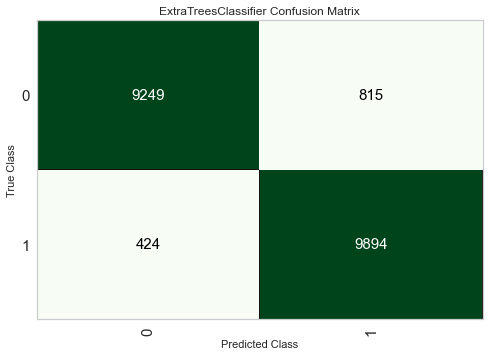

In [89]:
plot_model(et, plot = 'confusion_matrix')

### Extra Trees Classifier just guessed everything beyond belief really

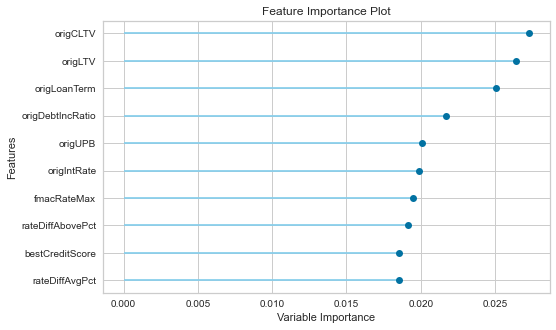

In [90]:
plot_model(et, plot = 'feature')

## Tune Models

### Extra Trees Classifier

In [327]:
#tuned_et = tune_model(et) # fold=10

In [323]:
#create a boosting model
et_boosted = create_model('et', ensemble = True, method = 'Boosting')

#calibrate boosted et
calibrated_et = calibrate_model(et_boosted)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9521,0.9796,0.9086,0.9964,0.9505,0.9042
1,0.9598,0.9855,0.9223,0.9982,0.9588,0.9197
2,0.9573,0.9842,0.9169,0.9986,0.9561,0.9147
3,0.9546,0.9819,0.9157,0.9941,0.9533,0.9092
4,0.9579,0.9841,0.9186,0.9982,0.9567,0.9160
5,0.9556,0.9834,0.9165,0.9955,0.9544,0.9113
6,0.9502,0.9827,0.9057,0.9954,0.9484,0.9004
7,0.9556,0.9838,0.9144,0.9977,0.9543,0.9113
8,0.9533,0.9842,0.9123,0.9950,0.9519,0.9067
9,0.9527,0.9827,0.9107,0.9955,0.9512,0.9054


### Extra Trees had marked increases and some decreases
#### Improved:     Accuracy AUC Precision F1   Kappa    
#### Declined: Recall 
                     Accur   AUC	    Recall	Prec.	F1	    Kappa	MCC
    Untuned:  Mean	0.9284	0.9827	0.9504	0.9120	0.9308	0.8568
    Tuned:    Mean	0.9549	0.9832	0.9142	0.9965	0.9535	0.9099

In [324]:
#optimize threshold for trained model
optimize_threshold(calibrated_et, true_negative = 100000, false_negative = -50000, true_positive = 50000, false_positive = -100000)

Optimized Probability Threshold: 0.54 | Optimized Cost Function: 1457300000


In [328]:
# predictions on hold-out set
et_pred_holdout = predict_model(calibrated_et,probability_threshold=0.54)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Calibrated Classifier C V,0.9682,0.9868,0.9374,0.9998,0.9676,0.9365


In [288]:
#optimize threshold for trained model
optimize_threshold(et, true_negative = 100000, false_negative = -50000, true_positive = 50000, false_positive = -100000)

Optimized Probability Threshold: 0.71 | Optimized Cost Function: 1336700000


In [289]:
# predictions on hold-out set
et_pred_holdout = predict_model(et,probability_threshold=0.71)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Random Forest Classifier,0.9229,0.9737,0.8752,0.9695,0.9199,0.8459


# Evaluate Models

## Extra Trees Classifier ("Fast Set" - some plots take longer and they are commented out

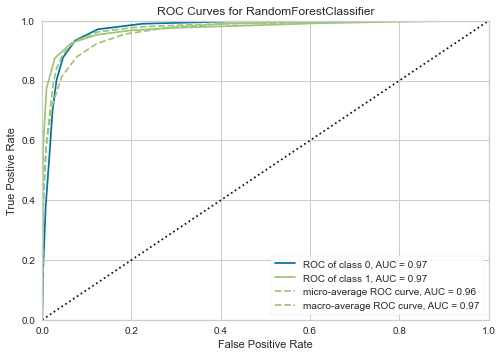

In [291]:
plot_model(et) #Super Fast

In [292]:
#plot_model(et, plot = 'threshold') #Medium Speed

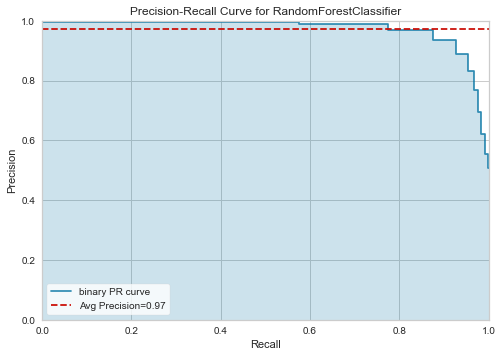

In [293]:
plot_model(et, plot = 'pr')  #Super Fast

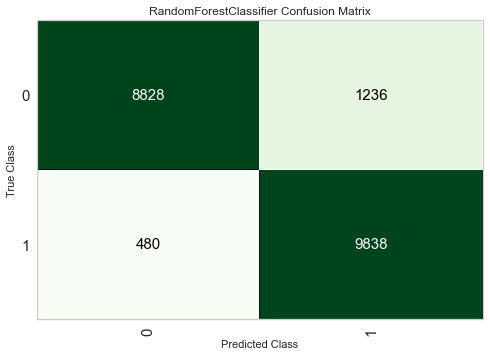

In [294]:
plot_model(et, plot='confusion_matrix') #Super Fast

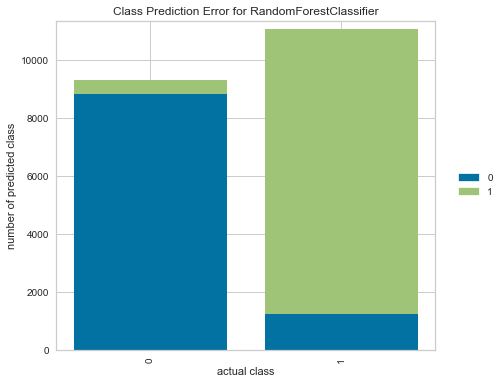

In [295]:
plot_model(et, plot = 'error') #Super Fast

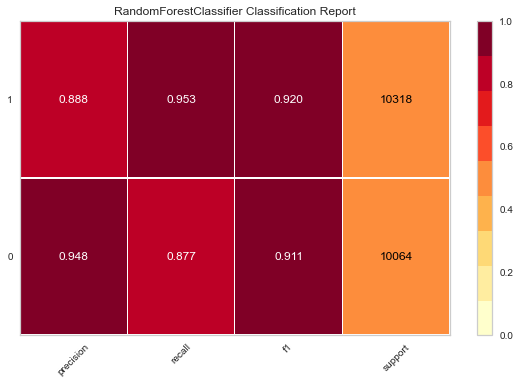

In [296]:
plot_model(et, plot = 'class_report') #Super Fast

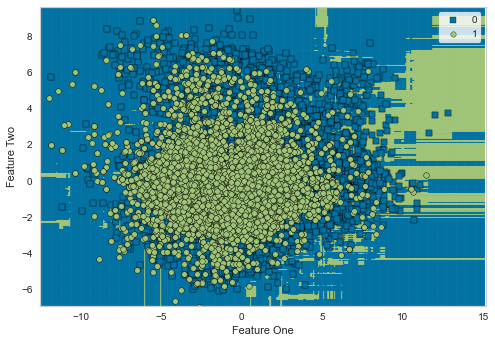

In [297]:
plot_model(et, plot = 'boundary') #Super Fast

In [298]:
#plot_model(et, plot='learning') #Slow

In [299]:
#plot_model(et, plot = 'calibration') #Very Very Slow

In [300]:
#plot_model(et,, plot = 'vc') #Very Slow

In [301]:
#plot_model(et, plot='dimension')  # Slow

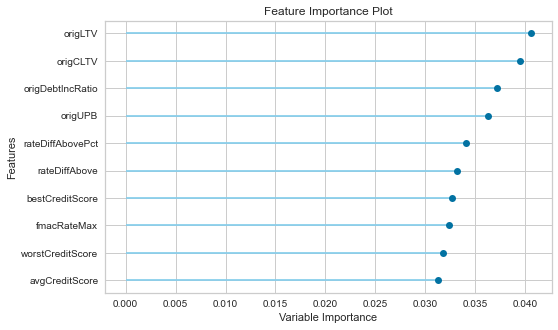

In [302]:
plot_model(et, plot = 'feature') #Super Fast

In [303]:
plot_model(et, plot = 'parameter') #Super Fast

,Parameters
bootstrap,True
ccp_alpha,0
class_weight,None
criterion,gini
max_depth,None
max_features,auto
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0
min_impurity_split,None


# The golden moment... put 10% sample test data through the models...

# Recombine test_features, test_target at first train/test/split
 This "test" set was split BEFORE Oversampling. PyCaret takes the "train" from this split and splits it internally again. Since we have no control of how PyCaret does this we needed to do a train/test split before we input the training set into PyCaret. Now we will recombine the test_features and test_target into one new df

In [304]:
test_features.shape

(6659, 185)

In [305]:
test_target.shape

(6659,)

In [306]:
test_df = test_features.copy()

In [307]:
test_df['zeroBalCode'] = test_target

In [308]:
test_df.shape

(6659, 186)

In [309]:
totalTestCount = test_df.zeroBalCode.value_counts().sum()
posTestCount = test_df.zeroBalCode.value_counts()[1]
print('#############################################')
print('This "Test" set has not been oversamplied')
print(test_df.zeroBalCode.value_counts())
print(f'Positive samples are {round(posTestCount/totalTestCount*100,2)}%')

#############################################
This "Test" set has not been oversamplied
0    5530
1    1129
Name: zeroBalCode, dtype: int64
Positive samples are 16.95%


# Calibrated Extra Trees Classifier

In [310]:
predictions = predict_model(calibrated_et, probability_threshold=0.54, data=test_df)

In [311]:
pd.set_option('max_columns',None)
predictions.head()

,origIntRate,origUPB,origLoanTerm,origLTV,origCLTV,numBorrowers,origDebtIncRatio,zipCode,pMIperct,mortInsType,bestCreditScore,worstCreditScore,avgCreditScore,mSA,fmacRateMax,fmacRateMin,fmacRateAvg,fmacRateVolatility,fredRate,rateDiffAbove,rateDiffBelow,rateDiffAvg,rateDiffAbovePct,rateDiffBelowPct,rateDiffAvgPct,C,R,"AMERIHOME MORTGAGE COMPANY, LLC",AMERISAVE MORTGAGE CORPORATION,AMTRUST BANK,"ASSOCIATED BANK, NA","BANK OF AMERICA, N.A.",BISHOPS GATE RESIDENTIAL MORTGAGE TRUST,"CALIBER HOME LOANS, INC.","CAPITAL ONE, NATIONAL ASSOCIATION","CASHCALL, INC.",CHASE HOME FINANCE,CHASE HOME FINANCE (CIE 1),CHASE HOME FINANCE FRANKLIN AMERICAN MORTGAGE COMPANY,"CHASE HOME FINANCE, LLC",CHICAGO MORTGAGE SOLUTIONS DBA INTERBANK MORTGAGE COMPANY,CHICAGO MORTGAGE SOLUTIONS DBA INTERFIRST MORTGAGE COMPANY,"CITIMORTGAGE, INC.","CITIZENS BANK, NATIONAL ASSOCIATION",CITIZENS MORTGAGE CORPORATION,"CMG MORTGAGE, INC",COLORADO FEDERAL SAVINGS BANK,DITECH FINANCIAL LLC,"DOWNEY SAVINGS AND LOAN ASSOCIATION, F.A.","EAGLE HOME MORTGAGE, LLC",EVERBANK,FAIRWAY INDEPENDENT MORTGAGE CORPORATION,"FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB",FEDERAL HOME LOAN BANK OF CHICAGO,FIFTH THIRD BANK,FINANCE OF AMERICA MORTGAGE LLC,FIRST BANK DBA FIRST BANK MORTGAGE,FIRST TENNESSEE BANK NATIONAL ASSOCIATION,"FLAGSTAR BANK, FSB",FLAGSTAR CAPITAL MARKETS CORPORATION,FLEET NATIONAL BANK,FRANKLIN AMERICAN MORTGAGE COMPANY,FREEDOM MORTGAGE CORP.,FREMONT BANK,"GE MORTGAGE SERVICES, LLC","GMAC MORTGAGE, LLC","GMAC MORTGAGE, LLC (USAA FEDERAL SAVINGS BANK)",GUILD MORTGAGE COMPANY,"HARWOOD STREET FUNDING I, LLC","HOMEBRIDGE FINANCIAL SERVICES, INC.","HOMEWARD RESIDENTIAL, INC.","HSBC BANK USA, NATIONAL ASSOCIATION",IMPAC MORTGAGE CORP.,"IRWIN MORTGAGE, CORPORATION","J.P. MORGAN MADISON AVENUE SECURITIES TRUST, SERIES 2014-1","J.P. MORGAN MADISON AVENUE SECURITIES TRUST, SERIES 2015-1","JP MORGAN CHASE BANK, NA","JPMORGAN CHASE BANK, NA","JPMORGAN CHASE BANK, NATIONAL ASSOCIATION","LAKEVIEW LOAN SERVICING, LLC","LOANDEPOT.COM, LLC","METLIFE BANK, NA",METLIFE HOME LOANS LLC,"MOVEMENT MORTGAGE, LLC","NATIONSTAR MORTGAGE, LLC",NETBANK FUNDING SERVICES,NEW YORK COMMUNITY BANK,"NYCB MORTGAGE COMPANY, LLC",OLD KENT MORTGAGE COMPANY,OTHER,"PACIFIC UNION FINANCIAL, LLC",PENNYMAC CORP.,PHH MORTGAGE CORPORATION,PHH MORTGAGE CORPORATION (USAA FEDERAL SAVINGS BANK),PMT CREDIT RISK TRANSFER TRUST 2015-2,PMT CREDIT RISK TRANSFER TRUST 2016-1,PMTT4,"PNC BANK, N.A.","PRINCIPAL RESIDENTIAL MORTGAGE CAPITAL RESOURCES, LLC","PROSPECT MORTGAGE, LLC","PROVIDENT FUNDING ASSOCIATES, L.P.","PULTE MORTGAGE, L.L.C.",QUICKEN LOANS INC.,RBC MORTGAGE COMPANY,REGIONS BANK,ROUNDPOINT MORTGAGE COMPANY,"SANTANDER BANK, NATIONAL ASSOCIATION","SIERRA PACIFIC MORTGAGE COMPANY, INC.","STEARNS LENDING, LLC",STONEGATE MORTGAGE CORPORATION,SUNTRUST BANK,SUNTRUST MORTGAGE INC.,THE BRANCH BANKING AND TRUST COMPANY,THE HUNTINGTON NATIONAL BANK,THIRD FEDERAL SAVINGS AND LOAN,TRUIST BANK (FORMERLY SUNTRUST BANK),U.S. BANK N.A.,"UNITED SHORE FINANCIAL SERVICES, LLC D/B/A UNITED WHOLESALE MORTGAGE","UNITED SHORE FINANCIAL SERVICES, LLC DBA UNITED WHOLESALE MORTGAGE",USAA DIRECT DELIVERY,USAA FEDERAL SAVINGS BANK,WASHTENAW MORTGAGE COMPANY,"WELLS FARGO BANK, NA","WELLS FARGO BANK, N.A.",WELLS FARGO CREDIT RISK TRANSFER SECURITIES TRUST 2015,"WITMER FUNDING, LLC",P,R.1,U,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,GU,HI,IA,ID,IL,IN,KS,KY,LA,MA,MD,ME,MI,MN,MO,MS,MT,NC,ND,NE,NH,NJ,NM,NV,NY,OH,OK,OR,PA,PR,RI,SC,SD,TN,TX,UT,VA,VI,VT,WA,WI,WV,WY,rank,origYear,origMonth,zeroBalCode,Label,Score
0,5.375,107000,360,95,95.0,2,36,378,30.0,1,658,658,658,0,5.26,5.21,5.230,0.009597,3.37,0.115,-0.165,0.145,0.021863,-0.031670,0.027725,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3,2003,6,

In [312]:
results = predictions[['zeroBalCode','Label','Score']]

In [316]:
results.Label.value_counts()

0    6659
Name: Label, dtype: int64

In [318]:
# totalPredCount = results.Label.value_counts().sum()
# posPredCount = results.Label.value_counts()[1]
# print('#############################################')
# print('This "Predicted" set has not been oversamplied')
# print(results.Label.value_counts())
# print(f'Positive samples are {round(posPredCount/totalPredCount*100,2)}%')

In [319]:
results['Confusion'] = results.apply(calc_confusion, axis=1)

In [320]:
confusionMatrix = results.Confusion.value_counts().to_dict()

In [321]:
print(f'           ##############################')
print(f'           #             #              #')
print(f'         0 #    {confusionMatrix["TrueNegative"]}     #     {confusionMatrix["FalsePositive"]}      #')
print(f'  True     #             #              #')
print(f'  Class    ##############################')
print(f'           #             #              #')
print(f'         1 #    {confusionMatrix["FalseNegative"]}       #     {confusionMatrix["TruePositive"]}       #')
print(f'           #             #              #')
print(f'           ##############################')
print(f'                  0              1        ')
print(f'                  Predicted Class           ')

           ##############################
           #             #              #
         0 #    5530     #     1129      #
  True     #             #              #
  Class    ##############################
           #             #              #


KeyError: 'FalseNegative'

In [322]:
# 0 or 2 = Predict equals truth, 1 = Predict doesn't equal truth
totalNegative = confusionMatrix['TrueNegative'] + confusionMatrix['FalseNegative']
totalPositive = confusionMatrix['TruePositive'] + confusionMatrix['FalsePositive']
trueNegativePct = confusionMatrix['TrueNegative'] / totalNegative * 100
falseNegativePct = confusionMatrix['FalseNegative'] / totalNegative * 100
truePositivePct = confusionMatrix['TruePositive'] / totalPositive * 100
falsePositivePct = confusionMatrix['FalsePositive'] / totalPositive * 100

print(f'TrueNegative:  {round(trueNegativePct,2)}%')
print(f'FalseNegative:  {round(falseNegativePct,2)}%')
print(f'TruePosiive:   {round(truePositivePct,2)}%')
print(f'FalsePositive: {round(falsePositivePct,2)}%')

KeyError: 'FalseNegative'

#### Well this is disappointing... The non-oversampled test dataset performed worse than random flipping a coin!

In [ ]:
#save_model(et, 'extraTrees2.5OsNorm_082220')

In [138]:
#save_model(calibrated_et, 'extraTreesCalibrated2.5OsNorm_082320')

# Extra Trees Classifier

In [224]:
predictions = predict_model(calibrated_et, data=test_df)

In [225]:
pd.set_option('max_columns',None)
predictions.head()

,origIntRate,origUPB,origLoanTerm,origLTV,origCLTV,numBorrowers,origDebtIncRatio,zipCode,pMIperct,mortInsType,bestCreditScore,worstCreditScore,avgCreditScore,mSA,fmacRateMax,fmacRateMin,fmacRateAvg,fmacRateVolatility,fredRate,rateDiffAbove,rateDiffBelow,rateDiffAvg,rateDiffAbovePct,rateDiffBelowPct,rateDiffAvgPct,C,R,"AMERIHOME MORTGAGE COMPANY, LLC",AMERISAVE MORTGAGE CORPORATION,AMTRUST BANK,"ASSOCIATED BANK, NA","BANK OF AMERICA, N.A.",BISHOPS GATE RESIDENTIAL MORTGAGE TRUST,"CALIBER HOME LOANS, INC.","CAPITAL ONE, NATIONAL ASSOCIATION","CASHCALL, INC.",CHASE HOME FINANCE,CHASE HOME FINANCE (CIE 1),CHASE HOME FINANCE FRANKLIN AMERICAN MORTGAGE COMPANY,"CHASE HOME FINANCE, LLC",CHICAGO MORTGAGE SOLUTIONS DBA INTERBANK MORTGAGE COMPANY,CHICAGO MORTGAGE SOLUTIONS DBA INTERFIRST MORTGAGE COMPANY,"CITIMORTGAGE, INC.","CITIZENS BANK, NATIONAL ASSOCIATION",CITIZENS MORTGAGE CORPORATION,"CMG MORTGAGE, INC",COLORADO FEDERAL SAVINGS BANK,DITECH FINANCIAL LLC,"DOWNEY SAVINGS AND LOAN ASSOCIATION, F.A.","EAGLE HOME MORTGAGE, LLC",EVERBANK,FAIRWAY INDEPENDENT MORTGAGE CORPORATION,"FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB",FEDERAL HOME LOAN BANK OF CHICAGO,FIFTH THIRD BANK,FINANCE OF AMERICA MORTGAGE LLC,FIRST BANK DBA FIRST BANK MORTGAGE,FIRST TENNESSEE BANK NATIONAL ASSOCIATION,"FLAGSTAR BANK, FSB",FLAGSTAR CAPITAL MARKETS CORPORATION,FLEET NATIONAL BANK,FRANKLIN AMERICAN MORTGAGE COMPANY,FREEDOM MORTGAGE CORP.,FREMONT BANK,"GE MORTGAGE SERVICES, LLC","GMAC MORTGAGE, LLC","GMAC MORTGAGE, LLC (USAA FEDERAL SAVINGS BANK)",GUILD MORTGAGE COMPANY,"HARWOOD STREET FUNDING I, LLC","HOMEBRIDGE FINANCIAL SERVICES, INC.","HOMEWARD RESIDENTIAL, INC.","HSBC BANK USA, NATIONAL ASSOCIATION",IMPAC MORTGAGE CORP.,"IRWIN MORTGAGE, CORPORATION","J.P. MORGAN MADISON AVENUE SECURITIES TRUST, SERIES 2014-1","J.P. MORGAN MADISON AVENUE SECURITIES TRUST, SERIES 2015-1","JP MORGAN CHASE BANK, NA","JPMORGAN CHASE BANK, NA","JPMORGAN CHASE BANK, NATIONAL ASSOCIATION","LAKEVIEW LOAN SERVICING, LLC","LOANDEPOT.COM, LLC","METLIFE BANK, NA",METLIFE HOME LOANS LLC,"MOVEMENT MORTGAGE, LLC","NATIONSTAR MORTGAGE, LLC",NETBANK FUNDING SERVICES,NEW YORK COMMUNITY BANK,"NYCB MORTGAGE COMPANY, LLC",OLD KENT MORTGAGE COMPANY,OTHER,"PACIFIC UNION FINANCIAL, LLC",PENNYMAC CORP.,PHH MORTGAGE CORPORATION,PHH MORTGAGE CORPORATION (USAA FEDERAL SAVINGS BANK),PMT CREDIT RISK TRANSFER TRUST 2015-2,PMT CREDIT RISK TRANSFER TRUST 2016-1,PMTT4,"PNC BANK, N.A.","PRINCIPAL RESIDENTIAL MORTGAGE CAPITAL RESOURCES, LLC","PROSPECT MORTGAGE, LLC","PROVIDENT FUNDING ASSOCIATES, L.P.","PULTE MORTGAGE, L.L.C.",QUICKEN LOANS INC.,RBC MORTGAGE COMPANY,REGIONS BANK,ROUNDPOINT MORTGAGE COMPANY,"SANTANDER BANK, NATIONAL ASSOCIATION","SIERRA PACIFIC MORTGAGE COMPANY, INC.","STEARNS LENDING, LLC",STONEGATE MORTGAGE CORPORATION,SUNTRUST BANK,SUNTRUST MORTGAGE INC.,THE BRANCH BANKING AND TRUST COMPANY,THE HUNTINGTON NATIONAL BANK,THIRD FEDERAL SAVINGS AND LOAN,TRUIST BANK (FORMERLY SUNTRUST BANK),U.S. BANK N.A.,"UNITED SHORE FINANCIAL SERVICES, LLC D/B/A UNITED WHOLESALE MORTGAGE","UNITED SHORE FINANCIAL SERVICES, LLC DBA UNITED WHOLESALE MORTGAGE",USAA DIRECT DELIVERY,USAA FEDERAL SAVINGS BANK,WASHTENAW MORTGAGE COMPANY,"WELLS FARGO BANK, NA","WELLS FARGO BANK, N.A.",WELLS FARGO CREDIT RISK TRANSFER SECURITIES TRUST 2015,"WITMER FUNDING, LLC",P,R.1,U,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,GU,HI,IA,ID,IL,IN,KS,KY,LA,MA,MD,ME,MI,MN,MO,MS,MT,NC,ND,NE,NH,NJ,NM,NV,NY,OH,OK,OR,PA,PR,RI,SC,SD,TN,TX,UT,VA,VI,VT,WA,WI,WV,WY,rank,origYear,origMonth,zeroBalCode,Label,Score
0,5.375,107000,360,95,95.0,2,36,378,30.0,1,658,658,658,0,5.26,5.21,5.230,0.009597,3.37,0.115,-0.165,0.145,0.021863,-0.031670,0.027725,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3,2003,6,

In [226]:
results = predictions[['zeroBalCode','Label','Score']]

In [227]:
predictions.Label.value_counts()

0    4468
1    2191
Name: Label, dtype: int64

In [228]:
def calc_confusion(row):
    if ((row['zeroBalCode'] == 0) & (row['Label'] == 0)):
        value = 'TrueNegative'
    elif ((row['zeroBalCode'] == 0) & (row['Label'] == 1)):
        value = 'FalseNegative'
    elif ((row['zeroBalCode'] == 1) & (row['Label'] == 1)):
        value = 'TruePositive'
    elif ((row['zeroBalCode'] == 1) & (row['Label'] == 0)):
        value = 'FalsePositive'
    else:
        value = 'Undefined'
    return value

In [229]:
results['Confusion'] = results.apply(calc_confusion, axis=1)

In [230]:
confusionMatrix = results.Confusion.value_counts().to_dict()

In [231]:
print(f'           ##############################')
print(f'           #             #              #')
print(f'         0 #    {confusionMatrix["TrueNegative"]}     #     {confusionMatrix["FalsePositive"]}      #')
print(f'  True     #             #              #')
print(f'  Class    ##############################')
print(f'           #             #              #')
print(f'         1 #    {confusionMatrix["FalseNegative"]}       #     {confusionMatrix["TruePositive"]}       #')
print(f'           #             #              #')
print(f'           ##############################')
print(f'                  0              1        ')
print(f'                  Predicted Class           ')

           ##############################
           #             #              #
         0 #    4070     #     398      #
  True     #             #              #
  Class    ##############################
           #             #              #
         1 #    1460       #     731       #
           #             #              #
           ##############################
                  0              1        
                  Predicted Class           


In [232]:
# 0 or 2 = Predict equals truth, 1 = Predict doesn't equal truth
totalNegative = confusionMatrix['TrueNegative'] + confusionMatrix['FalseNegative']
totalPositive = confusionMatrix['TruePositive'] + confusionMatrix['FalsePositive']
trueNegativePct = confusionMatrix['TrueNegative'] / totalNegative * 100
falseNegativePct = confusionMatrix['FalseNegative'] / totalNegative * 100
truePositivePct = confusionMatrix['TruePositive'] / totalPositive * 100
falsePositivePct = confusionMatrix['FalsePositive'] / totalPositive * 100

print(f'TrueNegative:  {round(trueNegativePct,2)}%')
print(f'FalseNegative:  {round(falseNegativePct,2)}%')
print(f'TruePosiive:   {round(truePositivePct,2)}%')
print(f'FalsePositive: {round(falsePositivePct,2)}%')

TrueNegative:  73.6%
FalseNegative:  26.4%
TruePosiive:   64.75%
FalsePositive: 35.25%


#### Well this is disappointing... The non-oversampled test dataset performed worse than random flipping a coin!

In [233]:
#save_model(et, 'extraTrees2.5OsNorm_082220')

In [138]:
#save_model(calibrated_et, 'extraTreesCalibrated2.5OsNorm_082320')

## Create models 

## Random Forest Classifier

In [237]:
rf = create_model('rf', fold=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9071,0.9645,0.9310,0.8903,0.9102,0.8140
1,0.9119,0.9714,0.9427,0.8898,0.9155,0.8236
2,0.9079,0.9698,0.9444,0.8821,0.9122,0.8156
3,0.9064,0.9667,0.9423,0.8812,0.9107,0.8127
4,0.9100,0.9688,0.9423,0.8870,0.9138,0.8198
5,0.9039,0.9675,0.9414,0.8777,0.9084,0.8076
6,0.8999,0.9644,0.9335,0.8767,0.9042,0.7996
7,0.9070,0.9673,0.9393,0.8842,0.9110,0.8139
8,0.9096,0.9666,0.9435,0.8854,0.9135,0.8190
9,0.9045,0.9678,0.9402,0.8795,0.9088,0.8088


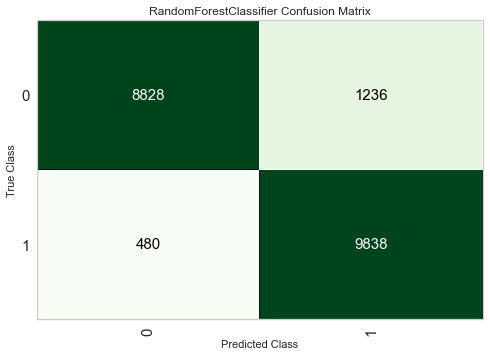

In [238]:
plot_model(rf, plot = 'confusion_matrix')

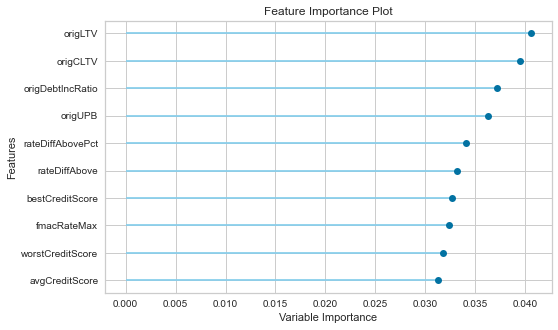

In [239]:
plot_model(rf, plot = 'feature')

## Tune Models

### Random Forest Classifier

In [236]:
#%tb
#tuned_et = tune_model(et) # fold=10

### Extra Trees had marked decreases on all metrics!!
#### Improved:     Recall    
#### Declined: Accuracy AUC Precision F1   Kappa
                    AccuracyAUC	    Recall	Prec.	F1	    Kappa	MCC
    Untuned:  Mean	0.9194	0.9733	0.9236	0.9159	0.9197	0.8387	0.8388
    Tuned:    Mean	0.8968	0.9697	0.938	0.8666	0.9009	0.7936	0.7964

In [240]:
#create a boosting model
rf_boosted = create_model('rf', ensemble = True, method = 'Boosting')

#calibrate trainde boosted dt
calibrated_rf = calibrate_model(rf_boosted)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9514,0.9791,0.9161,0.9870,0.9502,0.9029
1,0.9573,0.9836,0.9248,0.9902,0.9564,0.9147
2,0.9548,0.9841,0.9228,0.9871,0.9539,0.9096
3,0.9531,0.9807,0.9223,0.9840,0.9522,0.9063
4,0.9563,0.9831,0.9265,0.9863,0.9555,0.9126
5,0.9535,0.9825,0.9244,0.9828,0.9527,0.9071
6,0.9478,0.9813,0.9119,0.9839,0.9465,0.8958
7,0.9546,0.9837,0.9215,0.9880,0.9536,0.9092
8,0.9521,0.9820,0.9173,0.9870,0.9509,0.9042
9,0.9510,0.9820,0.9161,0.9861,0.9498,0.9021


In [241]:
#optimize threshold for trained model
optimize_threshold(calibrated_rf, true_negative = 100, false_negative = -5000, true_positive = 1000, false_positive = -500)

Optimized Probability Threshold: 0.15 | Optimized Cost Function: 8662200


In [258]:
# predictions on hold-out set
rf_pred_holdout = predict_model(calibrated_rf,probability_threshold=0.15)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Calibrated Classifier C V,0.8706,0.9869,0.9806,0.8059,0.8847,0.7405


In [243]:
#optimize threshold for trained model
optimize_threshold(rf, true_negative = 10, false_negative = -5000, true_positive = 1000, false_positive = -500)

Optimized Probability Threshold: 0.34 | Optimized Cost Function: 7445970


In [259]:
# predictions on hold-out set
rf_pred_holdout = predict_model(rf,probability_threshold=0.34)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Random Forest Classifier,0.8403,0.9737,0.9768,0.7696,0.8609,0.6794


# Evaluate Models

## Random Forest Classifier ("Fast Set" - some plots take longer and they are commented out

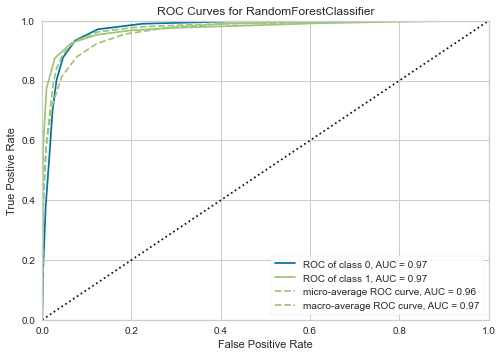

In [245]:
plot_model(rf) #Super Fast

In [246]:
#plot_model(rf, plot = 'threshold') #Medium Speed

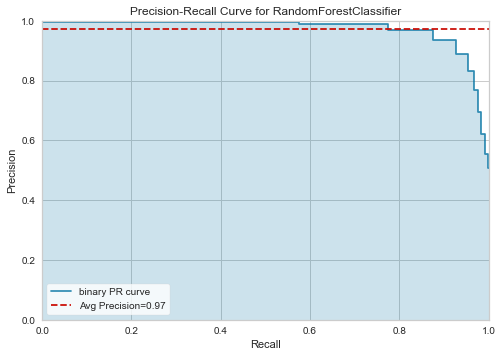

In [247]:
plot_model(rf, plot = 'pr')  #Super Fast

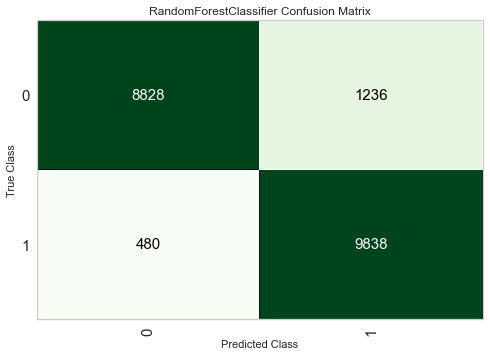

In [248]:
plot_model(rf, plot='confusion_matrix') #Super Fast

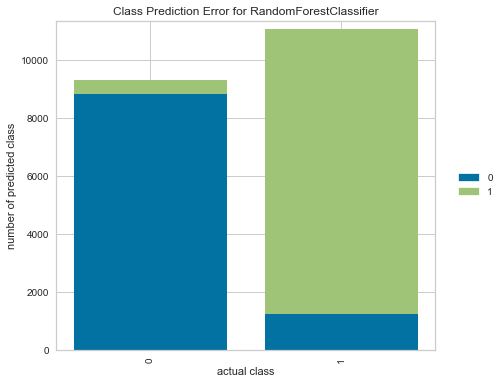

In [249]:
plot_model(rf, plot = 'error') #Super Fast

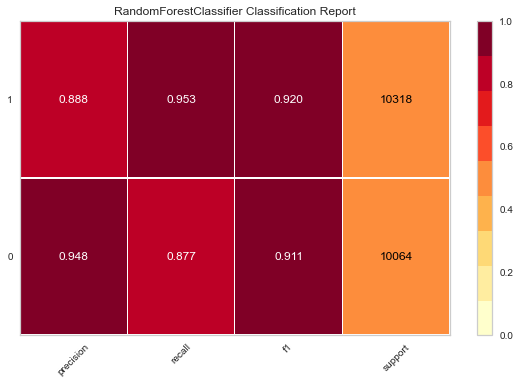

In [250]:
plot_model(rf, plot = 'class_report') #Super Fast

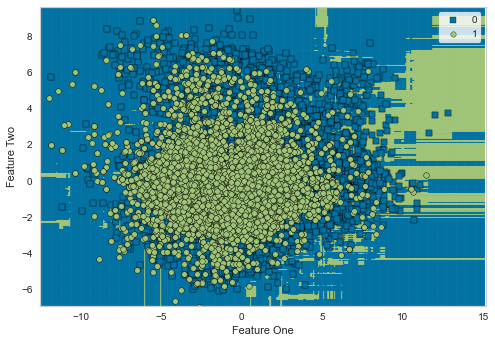

In [251]:
plot_model(rf, plot = 'boundary') #Super Fast

In [252]:
#plot_model(rf, plot='learning') #Slow

In [253]:
#plot_model(rf, plot = 'calibration') #Very Very Slow

In [254]:
#plot_model(rf,, plot = 'vc') #Very Slow

In [255]:
#plot_model(rf, plot='dimension')  # Slow

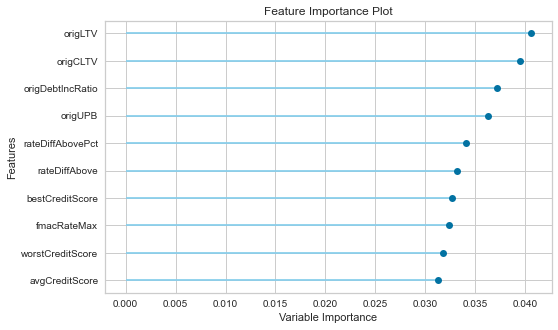

In [256]:
plot_model(rf, plot = 'feature') #Super Fast

In [257]:
plot_model(rf, plot = 'parameter') #Super Fast

,Parameters
bootstrap,True
ccp_alpha,0
class_weight,None
criterion,gini
max_depth,None
max_features,auto
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0
min_impurity_split,None


# The golden moment... put 10% sample test data through the models...

# Recombine test_features, test_target at first train/test/split
 This "test" set was split BEFORE Oversampling. PyCaret takes the "train" from this split and splits it internally again. Since we have no control of how PyCaret does this we needed to do a train/test split before we input the training set into PyCaret. Now we will recombine the test_features and test_target into one new df

In [260]:
test_features.shape

(6659, 185)

In [261]:
test_target.shape

(6659,)

In [262]:
test_df = test_features.copy()

In [263]:
test_df['zeroBalCode'] = test_target

In [264]:
test_df.shape

(6659, 186)

In [265]:
totalTestCount = test_df.zeroBalCode.value_counts().sum()
posTestCount = test_df.zeroBalCode.value_counts()[1]
print('#############################################')
print('This "Test" set has not been oversamplied')
print(test_df.zeroBalCode.value_counts())
print(f'Positive samples are {round(posTestCount/totalTestCount*100,2)}%')

#############################################
This "Test" set has not been oversamplied
0    5530
1    1129
Name: zeroBalCode, dtype: int64
Positive samples are 16.95%


# Calibrated Random Forest Classifier

In [266]:
predictions = predict_model(calibrated_rf, probability_threshold=0.13, data=test_df)

In [267]:
pd.set_option('max_columns',None)
predictions.head()

,origIntRate,origUPB,origLoanTerm,origLTV,origCLTV,numBorrowers,origDebtIncRatio,zipCode,pMIperct,mortInsType,bestCreditScore,worstCreditScore,avgCreditScore,mSA,fmacRateMax,fmacRateMin,fmacRateAvg,fmacRateVolatility,fredRate,rateDiffAbove,rateDiffBelow,rateDiffAvg,rateDiffAbovePct,rateDiffBelowPct,rateDiffAvgPct,C,R,"AMERIHOME MORTGAGE COMPANY, LLC",AMERISAVE MORTGAGE CORPORATION,AMTRUST BANK,"ASSOCIATED BANK, NA","BANK OF AMERICA, N.A.",BISHOPS GATE RESIDENTIAL MORTGAGE TRUST,"CALIBER HOME LOANS, INC.","CAPITAL ONE, NATIONAL ASSOCIATION","CASHCALL, INC.",CHASE HOME FINANCE,CHASE HOME FINANCE (CIE 1),CHASE HOME FINANCE FRANKLIN AMERICAN MORTGAGE COMPANY,"CHASE HOME FINANCE, LLC",CHICAGO MORTGAGE SOLUTIONS DBA INTERBANK MORTGAGE COMPANY,CHICAGO MORTGAGE SOLUTIONS DBA INTERFIRST MORTGAGE COMPANY,"CITIMORTGAGE, INC.","CITIZENS BANK, NATIONAL ASSOCIATION",CITIZENS MORTGAGE CORPORATION,"CMG MORTGAGE, INC",COLORADO FEDERAL SAVINGS BANK,DITECH FINANCIAL LLC,"DOWNEY SAVINGS AND LOAN ASSOCIATION, F.A.","EAGLE HOME MORTGAGE, LLC",EVERBANK,FAIRWAY INDEPENDENT MORTGAGE CORPORATION,"FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB",FEDERAL HOME LOAN BANK OF CHICAGO,FIFTH THIRD BANK,FINANCE OF AMERICA MORTGAGE LLC,FIRST BANK DBA FIRST BANK MORTGAGE,FIRST TENNESSEE BANK NATIONAL ASSOCIATION,"FLAGSTAR BANK, FSB",FLAGSTAR CAPITAL MARKETS CORPORATION,FLEET NATIONAL BANK,FRANKLIN AMERICAN MORTGAGE COMPANY,FREEDOM MORTGAGE CORP.,FREMONT BANK,"GE MORTGAGE SERVICES, LLC","GMAC MORTGAGE, LLC","GMAC MORTGAGE, LLC (USAA FEDERAL SAVINGS BANK)",GUILD MORTGAGE COMPANY,"HARWOOD STREET FUNDING I, LLC","HOMEBRIDGE FINANCIAL SERVICES, INC.","HOMEWARD RESIDENTIAL, INC.","HSBC BANK USA, NATIONAL ASSOCIATION",IMPAC MORTGAGE CORP.,"IRWIN MORTGAGE, CORPORATION","J.P. MORGAN MADISON AVENUE SECURITIES TRUST, SERIES 2014-1","J.P. MORGAN MADISON AVENUE SECURITIES TRUST, SERIES 2015-1","JP MORGAN CHASE BANK, NA","JPMORGAN CHASE BANK, NA","JPMORGAN CHASE BANK, NATIONAL ASSOCIATION","LAKEVIEW LOAN SERVICING, LLC","LOANDEPOT.COM, LLC","METLIFE BANK, NA",METLIFE HOME LOANS LLC,"MOVEMENT MORTGAGE, LLC","NATIONSTAR MORTGAGE, LLC",NETBANK FUNDING SERVICES,NEW YORK COMMUNITY BANK,"NYCB MORTGAGE COMPANY, LLC",OLD KENT MORTGAGE COMPANY,OTHER,"PACIFIC UNION FINANCIAL, LLC",PENNYMAC CORP.,PHH MORTGAGE CORPORATION,PHH MORTGAGE CORPORATION (USAA FEDERAL SAVINGS BANK),PMT CREDIT RISK TRANSFER TRUST 2015-2,PMT CREDIT RISK TRANSFER TRUST 2016-1,PMTT4,"PNC BANK, N.A.","PRINCIPAL RESIDENTIAL MORTGAGE CAPITAL RESOURCES, LLC","PROSPECT MORTGAGE, LLC","PROVIDENT FUNDING ASSOCIATES, L.P.","PULTE MORTGAGE, L.L.C.",QUICKEN LOANS INC.,RBC MORTGAGE COMPANY,REGIONS BANK,ROUNDPOINT MORTGAGE COMPANY,"SANTANDER BANK, NATIONAL ASSOCIATION","SIERRA PACIFIC MORTGAGE COMPANY, INC.","STEARNS LENDING, LLC",STONEGATE MORTGAGE CORPORATION,SUNTRUST BANK,SUNTRUST MORTGAGE INC.,THE BRANCH BANKING AND TRUST COMPANY,THE HUNTINGTON NATIONAL BANK,THIRD FEDERAL SAVINGS AND LOAN,TRUIST BANK (FORMERLY SUNTRUST BANK),U.S. BANK N.A.,"UNITED SHORE FINANCIAL SERVICES, LLC D/B/A UNITED WHOLESALE MORTGAGE","UNITED SHORE FINANCIAL SERVICES, LLC DBA UNITED WHOLESALE MORTGAGE",USAA DIRECT DELIVERY,USAA FEDERAL SAVINGS BANK,WASHTENAW MORTGAGE COMPANY,"WELLS FARGO BANK, NA","WELLS FARGO BANK, N.A.",WELLS FARGO CREDIT RISK TRANSFER SECURITIES TRUST 2015,"WITMER FUNDING, LLC",P,R.1,U,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,GU,HI,IA,ID,IL,IN,KS,KY,LA,MA,MD,ME,MI,MN,MO,MS,MT,NC,ND,NE,NH,NJ,NM,NV,NY,OH,OK,OR,PA,PR,RI,SC,SD,TN,TX,UT,VA,VI,VT,WA,WI,WV,WY,rank,origYear,origMonth,zeroBalCode,Label,Score
0,5.375,107000,360,95,95.0,2,36,378,30.0,1,658,658,658,0,5.26,5.21,5.230,0.009597,3.37,0.115,-0.165,0.145,0.021863,-0.031670,0.027725,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3,2003,6,

In [268]:
results = predictions[['zeroBalCode','Label','Score']]

In [269]:
predictions.Label.value_counts()

0    4288
1    2371
Name: Label, dtype: int64

In [270]:
def calc_confusion(row):
    if ((row['zeroBalCode'] == 0) & (row['Label'] == 0)):
        value = 'TrueNegative'
    elif ((row['zeroBalCode'] == 0) & (row['Label'] == 1)):
        value = 'FalseNegative'
    elif ((row['zeroBalCode'] == 1) & (row['Label'] == 1)):
        value = 'TruePositive'
    elif ((row['zeroBalCode'] == 1) & (row['Label'] == 0)):
        value = 'FalsePositive'
    else:
        value = 'Undefined'
    return value

In [271]:
results['Confusion'] = results.apply(calc_confusion, axis=1)

In [272]:
confusionMatrix = results.Confusion.value_counts().to_dict()

In [273]:
print(f'           ##############################')
print(f'           #             #              #')
print(f'         0 #    {confusionMatrix["TrueNegative"]}     #     {confusionMatrix["FalsePositive"]}      #')
print(f'  True     #             #              #')
print(f'  Class    ##############################')
print(f'           #             #              #')
print(f'         1 #    {confusionMatrix["FalseNegative"]}       #     {confusionMatrix["TruePositive"]}       #')
print(f'           #             #              #')
print(f'           ##############################')
print(f'                  0              1        ')
print(f'                  Predicted Class           ')

           ##############################
           #             #              #
         0 #    3937     #     351      #
  True     #             #              #
  Class    ##############################
           #             #              #
         1 #    1593       #     778       #
           #             #              #
           ##############################
                  0              1        
                  Predicted Class           


In [274]:
# 0 or 2 = Predict equals truth, 1 = Predict doesn't equal truth
totalNegative = confusionMatrix['TrueNegative'] + confusionMatrix['FalseNegative']
totalPositive = confusionMatrix['TruePositive'] + confusionMatrix['FalsePositive']
trueNegativePct = confusionMatrix['TrueNegative'] / totalNegative * 100
falseNegativePct = confusionMatrix['FalseNegative'] / totalNegative * 100
truePositivePct = confusionMatrix['TruePositive'] / totalPositive * 100
falsePositivePct = confusionMatrix['FalsePositive'] / totalPositive * 100

print(f'TrueNegative:  {round(trueNegativePct,2)}%')
print(f'FalseNegative:  {round(falseNegativePct,2)}%')
print(f'TruePosiive:   {round(truePositivePct,2)}%')
print(f'FalsePositive: {round(falsePositivePct,2)}%')

TrueNegative:  71.19%
FalseNegative:  28.81%
TruePosiive:   68.91%
FalsePositive: 31.09%


#### Well this is disappointing... The non-oversampled test dataset performed worse than random flipping a coin!

In [ ]:
#save_model(et, 'extraTrees2.5OsNorm_082220')

In [138]:
#save_model(calibrated_et, 'extraTreesCalibrated2.5OsNorm_082320')

In [ ]:
# Predict models using the "Oversampled" test holdout within PyCaret

#### Extra Trees

pred_holdout = predict_model(et)

# Random Forest Classifier

In [275]:
predictions = predict_model(rf, probability_threshold=0.34, data=test_df)

In [276]:
pd.set_option('max_columns',None)
predictions.head()

,origIntRate,origUPB,origLoanTerm,origLTV,origCLTV,numBorrowers,origDebtIncRatio,zipCode,pMIperct,mortInsType,bestCreditScore,worstCreditScore,avgCreditScore,mSA,fmacRateMax,fmacRateMin,fmacRateAvg,fmacRateVolatility,fredRate,rateDiffAbove,rateDiffBelow,rateDiffAvg,rateDiffAbovePct,rateDiffBelowPct,rateDiffAvgPct,C,R,"AMERIHOME MORTGAGE COMPANY, LLC",AMERISAVE MORTGAGE CORPORATION,AMTRUST BANK,"ASSOCIATED BANK, NA","BANK OF AMERICA, N.A.",BISHOPS GATE RESIDENTIAL MORTGAGE TRUST,"CALIBER HOME LOANS, INC.","CAPITAL ONE, NATIONAL ASSOCIATION","CASHCALL, INC.",CHASE HOME FINANCE,CHASE HOME FINANCE (CIE 1),CHASE HOME FINANCE FRANKLIN AMERICAN MORTGAGE COMPANY,"CHASE HOME FINANCE, LLC",CHICAGO MORTGAGE SOLUTIONS DBA INTERBANK MORTGAGE COMPANY,CHICAGO MORTGAGE SOLUTIONS DBA INTERFIRST MORTGAGE COMPANY,"CITIMORTGAGE, INC.","CITIZENS BANK, NATIONAL ASSOCIATION",CITIZENS MORTGAGE CORPORATION,"CMG MORTGAGE, INC",COLORADO FEDERAL SAVINGS BANK,DITECH FINANCIAL LLC,"DOWNEY SAVINGS AND LOAN ASSOCIATION, F.A.","EAGLE HOME MORTGAGE, LLC",EVERBANK,FAIRWAY INDEPENDENT MORTGAGE CORPORATION,"FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB",FEDERAL HOME LOAN BANK OF CHICAGO,FIFTH THIRD BANK,FINANCE OF AMERICA MORTGAGE LLC,FIRST BANK DBA FIRST BANK MORTGAGE,FIRST TENNESSEE BANK NATIONAL ASSOCIATION,"FLAGSTAR BANK, FSB",FLAGSTAR CAPITAL MARKETS CORPORATION,FLEET NATIONAL BANK,FRANKLIN AMERICAN MORTGAGE COMPANY,FREEDOM MORTGAGE CORP.,FREMONT BANK,"GE MORTGAGE SERVICES, LLC","GMAC MORTGAGE, LLC","GMAC MORTGAGE, LLC (USAA FEDERAL SAVINGS BANK)",GUILD MORTGAGE COMPANY,"HARWOOD STREET FUNDING I, LLC","HOMEBRIDGE FINANCIAL SERVICES, INC.","HOMEWARD RESIDENTIAL, INC.","HSBC BANK USA, NATIONAL ASSOCIATION",IMPAC MORTGAGE CORP.,"IRWIN MORTGAGE, CORPORATION","J.P. MORGAN MADISON AVENUE SECURITIES TRUST, SERIES 2014-1","J.P. MORGAN MADISON AVENUE SECURITIES TRUST, SERIES 2015-1","JP MORGAN CHASE BANK, NA","JPMORGAN CHASE BANK, NA","JPMORGAN CHASE BANK, NATIONAL ASSOCIATION","LAKEVIEW LOAN SERVICING, LLC","LOANDEPOT.COM, LLC","METLIFE BANK, NA",METLIFE HOME LOANS LLC,"MOVEMENT MORTGAGE, LLC","NATIONSTAR MORTGAGE, LLC",NETBANK FUNDING SERVICES,NEW YORK COMMUNITY BANK,"NYCB MORTGAGE COMPANY, LLC",OLD KENT MORTGAGE COMPANY,OTHER,"PACIFIC UNION FINANCIAL, LLC",PENNYMAC CORP.,PHH MORTGAGE CORPORATION,PHH MORTGAGE CORPORATION (USAA FEDERAL SAVINGS BANK),PMT CREDIT RISK TRANSFER TRUST 2015-2,PMT CREDIT RISK TRANSFER TRUST 2016-1,PMTT4,"PNC BANK, N.A.","PRINCIPAL RESIDENTIAL MORTGAGE CAPITAL RESOURCES, LLC","PROSPECT MORTGAGE, LLC","PROVIDENT FUNDING ASSOCIATES, L.P.","PULTE MORTGAGE, L.L.C.",QUICKEN LOANS INC.,RBC MORTGAGE COMPANY,REGIONS BANK,ROUNDPOINT MORTGAGE COMPANY,"SANTANDER BANK, NATIONAL ASSOCIATION","SIERRA PACIFIC MORTGAGE COMPANY, INC.","STEARNS LENDING, LLC",STONEGATE MORTGAGE CORPORATION,SUNTRUST BANK,SUNTRUST MORTGAGE INC.,THE BRANCH BANKING AND TRUST COMPANY,THE HUNTINGTON NATIONAL BANK,THIRD FEDERAL SAVINGS AND LOAN,TRUIST BANK (FORMERLY SUNTRUST BANK),U.S. BANK N.A.,"UNITED SHORE FINANCIAL SERVICES, LLC D/B/A UNITED WHOLESALE MORTGAGE","UNITED SHORE FINANCIAL SERVICES, LLC DBA UNITED WHOLESALE MORTGAGE",USAA DIRECT DELIVERY,USAA FEDERAL SAVINGS BANK,WASHTENAW MORTGAGE COMPANY,"WELLS FARGO BANK, NA","WELLS FARGO BANK, N.A.",WELLS FARGO CREDIT RISK TRANSFER SECURITIES TRUST 2015,"WITMER FUNDING, LLC",P,R.1,U,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,GU,HI,IA,ID,IL,IN,KS,KY,LA,MA,MD,ME,MI,MN,MO,MS,MT,NC,ND,NE,NH,NJ,NM,NV,NY,OH,OK,OR,PA,PR,RI,SC,SD,TN,TX,UT,VA,VI,VT,WA,WI,WV,WY,rank,origYear,origMonth,zeroBalCode,Label,Score
0,5.375,107000,360,95,95.0,2,36,378,30.0,1,658,658,658,0,5.26,5.21,5.230,0.009597,3.37,0.115,-0.165,0.145,0.021863,-0.031670,0.027725,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3,2003,6,

In [277]:
results = predictions[['zeroBalCode','Label','Score']]

In [278]:
predictions.Label.value_counts()

0    4082
1    2577
Name: Label, dtype: int64

In [279]:
def calc_confusion(row):
    if ((row['zeroBalCode'] == 0) & (row['Label'] == 0)):
        value = 'TrueNegative'
    elif ((row['zeroBalCode'] == 0) & (row['Label'] == 1)):
        value = 'FalseNegative'
    elif ((row['zeroBalCode'] == 1) & (row['Label'] == 1)):
        value = 'TruePositive'
    elif ((row['zeroBalCode'] == 1) & (row['Label'] == 0)):
        value = 'FalsePositive'
    else:
        value = 'Undefined'
    return value

In [280]:
results['Confusion'] = results.apply(calc_confusion, axis=1)

In [281]:
confusionMatrix = results.Confusion.value_counts().to_dict()

In [282]:
print(f'           ##############################')
print(f'           #             #              #')
print(f'         0 #    {confusionMatrix["TrueNegative"]}     #     {confusionMatrix["FalsePositive"]}      #')
print(f'  True     #             #              #')
print(f'  Class    ##############################')
print(f'           #             #              #')
print(f'         1 #    {confusionMatrix["FalseNegative"]}       #     {confusionMatrix["TruePositive"]}       #')
print(f'           #             #              #')
print(f'           ##############################')
print(f'                  0              1        ')
print(f'                  Predicted Class           ')

           ##############################
           #             #              #
         0 #    3698     #     384      #
  True     #             #              #
  Class    ##############################
           #             #              #
         1 #    1832       #     745       #
           #             #              #
           ##############################
                  0              1        
                  Predicted Class           


In [283]:
# 0 or 2 = Predict equals truth, 1 = Predict doesn't equal truth
totalNegative = confusionMatrix['TrueNegative'] + confusionMatrix['FalseNegative']
totalPositive = confusionMatrix['TruePositive'] + confusionMatrix['FalsePositive']
trueNegativePct = confusionMatrix['TrueNegative'] / totalNegative * 100
falseNegativePct = confusionMatrix['FalseNegative'] / totalNegative * 100
truePositivePct = confusionMatrix['TruePositive'] / totalPositive * 100
falsePositivePct = confusionMatrix['FalsePositive'] / totalPositive * 100

print(f'TrueNegative:  {round(trueNegativePct,2)}%')
print(f'FalseNegative:  {round(falseNegativePct,2)}%')
print(f'TruePosiive:   {round(truePositivePct,2)}%')
print(f'FalsePositive: {round(falsePositivePct,2)}%')

TrueNegative:  66.87%
FalseNegative:  33.13%
TruePosiive:   65.99%
FalsePositive: 34.01%


#### Well this is disappointing... The non-oversampled test dataset performed worse than random flipping a coin!

## Finalize Model

### Extra Trees Classifier just guessed everything beyond belief really

In [233]:
#save_model(et, 'extraTrees2.5OsNorm_082220')

In [138]:
#save_model(calibrated_et, 'extraTreesCalibrated2.5OsNorm_082320')